### Imports

In [1]:
import gym

import matplotlib.pyplot as plt
import time

import snntorch as snn
from snntorch import spikegen, surrogate
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights, swin_v2_b, Swin_V2_B_Weights
import numpy as np

In [2]:
#vggNet = vgg16(weights = VGG16_Weights.IMAGENET1K_FEATURES, progress = True)
# vggNet.classifier = nn.Sequential()
# vggNet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
# print(vggNet)
# 
# #TODO:
# #nn.Linear(512, 128),
# #nn.Linear(128, 64)
#img = np.random.rand(3, 96, 96)
# print("input: ", img.shape)
#img = torch.tensor(img)
# 
# # Step 1: Initialize model with the best available weights
#weights = VGG16_Weights.IMAGENET1K_FEATURES
# vggNet.eval()
# 
# # Step 2: Initialize the inference transforms
#preprocess = weights.transforms()
# 
# # Step 3: Apply inference preprocessing transforms
#batch = preprocess(img).unsqueeze(0)
# 
# 
# out = vggNet(batch)
# print("output: ", out.shape)
# 
# # p = VGG16_Weights.IMAGENET1K_FEATURES.transforms
# # print(p)
# layer = snn.Leaky(beta=0.95, learn_threshold=False, spike_grad=surrogate.fast_sigmoid())
# print(layer)
# mem = layer.init_leaky()
# print(mem)
# print(type(mem))



# resnet = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1, progress = True)
# print(resnet)
# prp = ResNet18_Weights.IMAGENET1K_V1.transforms()
# img = np.random.rand(3, 96, 96)
# img = torch.tensor(img)
# 
# batch = prp(img).unsqueeze(0)
# 
# 
# out = resnet(batch)
# print("output: ", out.shape)
# 
# resnet.fc = nn.Sequential()

# model = swin_v2_b(weights = Swin_V2_B_Weights.IMAGENET1K_V1, progress = True)
# tr = Swin_V2_B_Weights.IMAGENET1K_V1.transforms()
# model.head=nn.Sequential()
# 
# img = np.random.rand(3, 96, 96)
# img = torch.tensor(img)
# model.eval()
# batch = tr(img).unsqueeze(0)
# out = model(batch)

### Defining the network

In [3]:
class Net(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs, beta=0.95):
        super(Net, self).__init__()

        spike_grad1 = surrogate.fast_sigmoid()
        spike_grad2 = surrogate.fast_sigmoid()
        spike_grad3 = surrogate.fast_sigmoid()
        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad1)
        # print(self.lif1)
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.lif2 = snn.Leaky(beta=beta, learn_threshold=False, spike_grad=spike_grad2)
        self.fc3 = nn.Linear(num_hidden, num_outputs)
        self.lif3 = snn.Leaky(
            beta=beta,
            learn_beta=True,
            threshold=1e5,
            reset_mechanism="none",
            spike_grad=spike_grad3,
        )

    def _convert_to_spikes(self, data): # TODO - MISSING
        return snn.spikegen.delta(data, threshold=0.1, padding=False, off_spike=True)

    def createGauss(self, mins, maxes, numPerDim, amplMax, dims):
        self.amplMax = amplMax
        self.numPerDim = numPerDim
        self.M = []
        self.sigma = []
        for i in range(dims):
            M, sigma = np.linspace(mins[i], maxes[i], numPerDim, retstep=True)
            self.M.append(M)
            self.sigma += [
                sigma,
            ] * self.numPerDim
        self.M = torch.tensor(
            np.array(self.M).reshape(-1, self.numPerDim), dtype=torch.float
        ).cuda()
        self.sigma = torch.tensor(
            np.array(self.sigma).reshape(-1, self.numPerDim), dtype=torch.float
        ).cuda()

    def gaussianCurrents(self, data):
        x = data.unsqueeze(-1).repeat([1, 1, self.numPerDim])
        return (
            torch.exp(-1 / 2 * ((x - self.M) / self.sigma) ** 2) * self.amplMax
        ).reshape(data.shape[0], -1)

    def forward(self, x, num_steps=16):

        x = self.gaussianCurrents(x)

        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        spk2_rec = []
        mem2_rec = []

        spk1_rec = []
        mem1_rec = []

        for step in range(num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(
                cur1,
                mem1,
            )
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            spk3_rec.append(spk3)
            mem3_rec.append(mem3)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

        return (
            x,
            [
                torch.stack(spk1_rec, dim=0),
                torch.stack(spk2_rec, dim=0),
                torch.stack(spk3_rec, dim=0),
                torch.stack(mem1_rec, dim=0),
                torch.stack(mem2_rec, dim=0),
                torch.stack(mem3_rec, dim=0),
            ],
            torch.stack(mem3_rec, dim=0),
        )

### Defining the Agent

In [4]:
class Agent(object):
    def __init__(
        self,
        lr,
        gamma,
        mem_size,
        n_actions,
        epsilon,
        batch_size,
        #input_dims,
        epsilon_dec=0.99988,
        epsilon_end=0.01,
        targetUpdateSteps=20,
        q_dir="tmp\\q",
        visualize=False,
        convnet = None,
        model_savedir = None
    ):
        self.visualize = visualize
        self.targetUpdateSteps = targetUpdateSteps
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.gamma = gamma
        self.mem_size = mem_size
        self.mem_cntr = 0
        self.stepnum = 0
        self.epsilon = epsilon
        self.epsilon_dec = epsilon_dec
        self.epsilon_end = epsilon_end
        self.batch_size = batch_size
        self.model_savedir = model_savedir

        self.dtype = torch.float
        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )
        
        if convnet is not None: ###########################
            if convnet == "VGG":
                self.convnet = vgg16(weights = VGG16_Weights.IMAGENET1K_FEATURES, progress = True).to(self.device)
                self.convnet.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
                self.convnet.classifier = nn.Sequential()
                self.convnet.eval()
                self.preprocess = VGG16_Weights.IMAGENET1K_FEATURES.transforms()
                
                self.conv_out_features = 512
                input_dims = [512]
            elif convnet == "resnet18":
                self.convnet = resnet18(weights = ResNet18_Weights.IMAGENET1K_V1, progress = True).to(self.device)
                self.convnet.fc = nn.Sequential()
                self.convnet.eval()
                self.preprocess = ResNet18_Weights.IMAGENET1K_V1.transforms()

                self.conv_out_features = 512
                input_dims = [512]
            elif convnet == "swin":
                self.convnet = swin_v2_b(weights = Swin_V2_B_Weights.IMAGENET1K_V1, progress = True).to(self.device)
                self.convnet.head=nn.Sequential()
                self.convnet.eval()
                self.preprocess = Swin_V2_B_Weights.IMAGENET1K_V1.transforms()
                
                self.conv_out_features = 1024
                input_dims = [1024]
            else:
                raise Exception(f"UNIMPLEMENTED convnet: {convnet}")
                
        self.low = np.array([-2]*self.conv_out_features).astype(np.float32)
        self.high = np.array([2]*self.conv_out_features).astype(np.float32)

        gaussPerDim = 64
        hiddenSize = 128
        self.q_net = Net(input_dims[0] * gaussPerDim, hiddenSize, n_actions).to(
            self.device
        )
        self.q_net.createGauss(self.low, self.high, gaussPerDim, 1.0, input_dims[0])
        self.t_net = Net(input_dims[0] * gaussPerDim, hiddenSize, n_actions).to(
            self.device
        )
        self.t_net.createGauss(self.low, self.high, gaussPerDim, 1.0, input_dims[0])
        self.t_net.load_state_dict(self.q_net.state_dict())

        # self.loss = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(
            self.q_net.parameters(), lr=lr, betas=(0.9, 0.999)
        )
        # self.q_eval = DeepQNetwork(lr, n_actions, input_dims=input_dims, name='q_eval', chkpt_dir=q_dir)

        self.state_memory = np.zeros((self.mem_size, *input_dims))
        self.new_state_memory = np.zeros((self.mem_size, *input_dims))
        self.action_memory = np.zeros((self.mem_size, self.n_actions), dtype=np.int8)
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.int8)
        
    def conv_image(self, image):
        image = image.transpose(2, 0, 1)
        image = torch.tensor(image).unsqueeze(0).to(self.device)
        return self.convnet(self.preprocess(image)).squeeze() ##############

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_memory[index] = actions
        self.terminal_memory[index] = 1 - terminal
        self.mem_cntr += 1

    def choose_action(self, state):
        state = state[np.newaxis, :] ## prolly change TODO
        rand = np.random.random()
        # print(self.epsilon)
        if rand < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            with torch.no_grad():
                self.q_net.eval()
                gaussX, spikes, actions = self.q_net(
                    state.to(self.device) #torch.tensor(state, dtype=self.dtype).to(self.device)
                )
                actions = actions.cpu()[-1, 0, :].detach().numpy()
                action = np.argmax(actions)
        return action

    def learn(self):
        if self.mem_cntr > self.batch_size:
            max_mem = self.mem_cntr if self.mem_cntr < self.mem_size else self.mem_size

            batch = np.random.choice(max_mem, self.batch_size)
            state_batch = self.state_memory[batch]
            new_state_batch = self.new_state_memory[batch]
            action_batch = self.action_memory[batch]
            action_values = np.array(self.action_space, dtype=np.int8)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = self.reward_memory[batch]
            terminal_batch = self.terminal_memory[batch]

            self.q_net.train()
            evalspikes, _, q_eval = self.q_net.forward(
                torch.tensor(state_batch, dtype=self.dtype).to(self.device)
            )
            q_eval = q_eval[-1, :, :]

            self.t_net.eval()
            _, _, q_next = self.t_net.forward(
                torch.tensor(new_state_batch, dtype=self.dtype).to(self.device)
            )

            q_next = q_next[-1, :, :]

            q_target = torch.clone(q_eval).detach()

            batch_index = np.arange(self.batch_size, dtype=np.int32)
            q_target[batch_index, action_indices] = (
                (
                    torch.tensor(reward_batch, device=self.device)
                    + torch.tensor(self.gamma, device=self.device)
                    * torch.max(q_next, dim=1).values
                    * torch.tensor(terminal_batch, device=self.device)
                )
                .type(self.dtype)
                .detach()
            )

            criterion = nn.MSELoss()
            loss = criterion(q_eval, q_target)
            self.optimizer.zero_grad()
            loss.backward()

            for param in self.q_net.parameters():
                if param.grad is not None:
                    param.grad.data.clamp_(-1, 1)
            self.optimizer.step()

            self.epsilon = (
                self.epsilon * self.epsilon_dec
                if self.epsilon > self.epsilon_end
                else self.epsilon_end
            )

            if self.stepnum % self.targetUpdateSteps == 0:
                self.t_net.load_state_dict(self.q_net.state_dict())

            self.stepnum += 1

    def save_models(self):
        torch.save(self.q_net.state_dict(), self.model_savedir)

    def load_models(self, load_dir):
        self.q_net.load_state_dict(torch.load(load_dir))
        self.q_net.eval()

### Setup

In [5]:
env = gym.make("CarRacing-v2", render_mode="rgb_array", continuous=False)
# env.seed(42)
lr = 0.001
agent = Agent(
    gamma=0.99,
    epsilon=0.3,
    lr=lr,
    #input_dims=[8],
    n_actions=5,
    mem_size=1000000,
    batch_size=128,
    epsilon_end=0.05,
    convnet = "swin",
    model_savedir = "swin"
)

# agent.load_models()

state = agent.q_net.state_dict()
state["lif1.beta"] = torch.tensor(0.95, dtype=torch.float).cuda()
state["lif2.beta"] = torch.tensor(0.95, dtype=torch.float).cuda()
state["lif3.beta"] = torch.tensor(1.0, dtype=torch.float).cuda()
agent.q_net.load_state_dict(state)
#print(agent.q_net.lif1.beta)

<All keys matched successfully>

### Running the training process

episode 0 score 0
frames alive:  7512
episode 1 score -827.2904761905723
frames alive:  38152
episode 2 score -3547.8272727251324
frames alive:  6072
episode 3 score -606.0169675090707
frames alive:  1667
episode 4 score -222.48235294117381
frames alive:  8833
episode 5 score -868.3851851853016
frames alive:  2162
episode 6 score -250.74052287581318
frames alive:  7374
episode 7 score -743.3402684564519
frames alive:  3414
episode 8 score -371.6135888501669
frames alive:  1651
episode 9 score -245.8306709265135
frames alive:  937
episode 10 score -167.2842105263162 average_score -785.081 epsilon 0.050
frames alive:  6275
episode 11 score -604.7006134969804
frames alive:  4539
episode 12 score -394.19087947882014
frames alive:  1986
episode 13 score -275.69869706839813
frames alive:  2745
episode 14 score -277.9714285714234
frames alive:  2015
episode 15 score -195.76619718309848
frames alive:  1460
episode 16 score -220.74276729559483
frames alive:  1510
episode 17 score -214.403649635

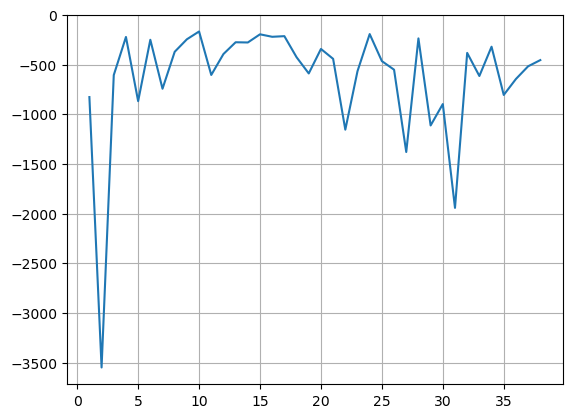

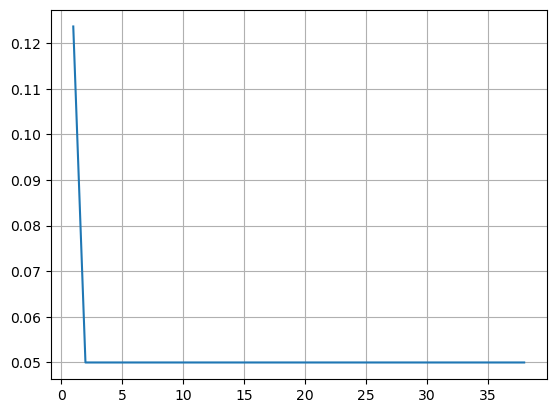

In [6]:
stime = time.time()
scores = []
eps_history = []
score = 0
i = -1
while time.time() - stime < 60 * 600:
    i += 1
    done = False
    if i % 10 == 0 and i > 0:
        avg_score = np.mean(scores[max(0, i - 10) : (i + 1)])
        print("episode", i, "score", score, "average_score %.3f" % avg_score, "epsilon %.3f" % agent.epsilon)
        agent.save_models()
    else:
        print("episode", i, "score", score)

    observation, _ = env.reset()
    #print("ob1: ", observation.shape)
    observation = agent.conv_image(observation)
    #print("ob2: ", observation.shape)
    score = 0
    j = 0
    while not done:
        if i % 5 == 0:
            env.render()
        
        #print("j: ", j)
        #print("s: ", scores)
        action = agent.choose_action(observation)
        #print('action: ', action)
        observation_, reward, done, info, _ = env.step(action)
        # print("reward: ", reward)
        # print("done: ", done)
        # print("info: ", info)
        observation_ = agent.conv_image(observation_)
        #print("score: ", score)
        score += reward
        #print("score: ", score)
        

        # print(score, reward)
        agent.store_transition(observation.detach().cpu(), action, reward, observation_.detach().cpu(), int(done))
        observation = observation_

        agent.learn()
        j+=1
    print("frames alive: ", j)
    #print(f"appended_scores: {scores}")
    scores.append(score)
    #print(f"appended_scores: {scores}")
    eps_history.append(agent.epsilon)

x = [idx + 1 for idx in range(i + 1)]
# print("x: ", x)
# print("scores: ", scores)
plt.figure(0)
plt.plot(x, scores)
plt.grid()
plt.figure(1)
plt.plot(x, eps_history)
plt.grid()
print("Total time: ", time.time() - stime)
plt.show()

### Evaluation

In [ ]:
input("Press Enter to start trials\n")

compscores = 0

agent.load_models()
print(agent.epsilon)
for i in range(5):
    done = False
    observation, _ = env.reset()
    score = 0
    while not done:
        env.render()
        action = agent.choose_action(observation)
        observation_, reward, done, info, _ = env.step(action)
        agent.store_transition(observation, action, reward, observation_, int(done))
        observation = observation_
        score += reward
    compscores += score
    print("Competitive round ", i + 1, " Overall score ", compscores)

with open("scoreboard.txt", "w") as f:
    f.writelines("%s: %i\n" % ("MIkro Lander", compscores))
input()